# Step 2

In step 2 you will be using **Pytorch** to import MNIST, train a neural network on MNIST, find examples that "fool" that trained network, and, if you're a 6505 student, propose a way to deal with these examples.

## Question 1

Start by importing both the training and testing MNIST datasets using DataLoaders and the torchvision provided datasets. You can set both the training and testing batch size to be whatever you feel is best.

IMPORTS

In [186]:
import torch
import torchvision as tv
import torch.utils.data as dataloader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

VARIABLE INITIALIZATION

In [187]:
batch_size_train = 64
batch_size_test = 64
alpha = 0.01
momentum = 0.5
epochs = 10
loss_list = []
test_loss_list = []
train_x_axis = []
test_x_axis = []

MNIST TRAINING DATASET IMPORT

In [188]:
MNIST_train_dataset = tv.datasets.MNIST('/files/', 
                                        train=True, 
                                        download=True, 
                                        transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

In [189]:
print(f"Number of Datapoints of Train Dataset: {len(MNIST_train_dataset)}")

Number of Datapoints of Train Dataset: 60000


SPLIT THE TRAINING DATASET

In [190]:
MNIST_train_dataset_1, MNIST_train_dataset_2 = dataloader.random_split(MNIST_train_dataset, [50000, 10000])

In [191]:
print(f"Number of Datapoints of Train Dataset 1: {len(MNIST_train_dataset_1)}")
print(f"Number of Datapoints of Train Dataset 2: {len(MNIST_train_dataset_2)}")

Number of Datapoints of Train Dataset 1: 50000
Number of Datapoints of Train Dataset 2: 10000


In [192]:
MNIST_train_dataloader_1 = dataloader.DataLoader(MNIST_train_dataset_1, 
                      batch_size=batch_size_train, 
                      shuffle=True)
MNIST_train_dataloader_2 = dataloader.DataLoader(MNIST_train_dataset_2, 
                      batch_size=batch_size_train, 
                      shuffle=True)

In [193]:
print(f"Batch Size of training dataset 1: {MNIST_train_dataloader_1.batch_size}")
print(f"Data Size of training dataset 2: {len(MNIST_train_dataloader_2.dataset)}")

Batch Size of training dataset 1: 64
Data Size of training dataset 2: 10000


MNIST TESTING DATASET IMPORT

In [194]:
MNIST_test_dataset = tv.datasets.MNIST('/files/', 
                                      train=False, 
                                      download=True, 
                                      transform=tv.transforms.Compose([tv.transforms.ToTensor()]))

In [195]:
print(f"Number of Datapoints of Test Dataset: {len(MNIST_test_dataset)}")

Number of Datapoints of Test Dataset: 10000


In [196]:
MNIST_test_dataloader = dataloader.DataLoader(MNIST_test_dataset, 
                      batch_size=batch_size_test, 
                      shuffle=True)

In [197]:
print(f"Batch Size of testing dataset: {MNIST_test_dataloader.batch_size}")

Batch Size of testing dataset: 64


## Question 2

Define a network with the following architecture:

Conv2d (input channels=1, output channels = 15,kernel size = 5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Conv2d (input channels=15, output channels = 30,kernel size = 5)
$\rightarrow$
Dropout2d (p = 0.5)
$\rightarrow$
MaxPool (kernel size = 2)
$\rightarrow$
ReLU
$\rightarrow$
Linear(input dimension = 480, hidden units = 64)
$\rightarrow$
ReLU
$\rightarrow$
Dropout (p=0.5)
$\rightarrow$
Linear(input dimension = 64, hidden units = 10)
$\rightarrow$
LogSoftMax

NEURAL NETWORK

In [198]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Conv2d(1, 15, kernel_size=5)
        self.layer2 = nn.Conv2d(15, 30, kernel_size=5)
        self.dropoutLayer = nn.Dropout2d(p=0.5)
        self.Z1 = nn.Linear(480, 64)
        self.Z2 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.layer1(x), 2))
        x = F.relu(F.max_pool2d(self.dropoutLayer(self.layer2(x)), 2))
        x = x.view(-1, 480)
        x = F.relu(self.Z1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.Z2(x)
        return F.log_softmax(x, dim=1)

## Question 3

Train the network you defined in the previous question on MNIST, using the optimizer and the number of training epochs you deem appropriate. Use a cross-entropy loss. Each epoch test your model on the testing dataset and print the value of the accuracy that you achieve. Produce a plot of the loss against the number of epochs.

**Note**: Do not be overly worried about the accuracy that you achieve with your model. It should be upwards of 95% at the very least, but you won't get bonus marks for training a model that has 99.x% accuracy.

CALL NEURAL NETWORK

In [199]:
neuralNetwork = NeuralNetwork()

ADD OPTIMIZER

In [200]:
optimizer = optim.SGD(neuralNetwork.parameters(), lr=alpha, momentum=momentum)

TRAIN THE NEURAL NETWORK

In [201]:
# For Plotting Graph
test_x_axis = [i*len(MNIST_train_dataloader_1.dataset) for i in range(1, epochs + 1)]

In [202]:
def train(epoch):
  neuralNetwork.train()

  for i, (data, target) in enumerate(MNIST_train_dataloader_1):
    optimizer.zero_grad()
    neuralNetworkOutput = neuralNetwork(data)

    # Calculate Cross-Entropy Loss
    crossEntropyLoss = F.nll_loss(neuralNetworkOutput, target)
    crossEntropyLoss.backward()

    optimizer.step()

    if i % 100 == 0:
      print(f"(Training)Epoch: {epoch} Iteration: {i} Loss: {crossEntropyLoss.item()}")
      
    # For Plotting Graph
    loss_list.append(crossEntropyLoss.item())
    
    train_x_axis.append(
      (i*64) + ((epoch-1)*len(MNIST_train_dataloader_1.dataset)))     

TEST THE NEURAL NETWORK

In [203]:
def test(epoch):
  average_loss = 0
  get_accuracy = 0

  neuralNetwork.eval()

  with torch.no_grad():

    for data, target in MNIST_test_dataloader:
      
      neuralNetworkOutput = neuralNetwork(data)

      average_loss += F.nll_loss(neuralNetworkOutput, target).item()

      # Calculate Accuracy
      predictedValue = neuralNetworkOutput.data.max(1, keepdim=True)[1]
      get_accuracy += predictedValue.eq(target.data.view_as(predictedValue)).sum()

  # Calculate Final Accuracy
  test_accuracy = 100. * get_accuracy / len(MNIST_test_dataloader.dataset)

  print(f"(Testing) Epoch: {epoch} ACCURACY: {test_accuracy}")

In [204]:
for epoch in range(1, epochs + 1):
  train(epoch)
  print('-----------------------------------------------------------')
  test(epoch)
  print('-----------------------------------------------------------')

(Training)Epoch: 1 Iteration: 0 Loss: 2.3116652965545654
(Training)Epoch: 1 Iteration: 100 Loss: 2.2783238887786865
(Training)Epoch: 1 Iteration: 200 Loss: 2.2492175102233887
(Training)Epoch: 1 Iteration: 300 Loss: 1.690593957901001
(Training)Epoch: 1 Iteration: 400 Loss: 1.2240930795669556
(Training)Epoch: 1 Iteration: 500 Loss: 0.6187265515327454
(Training)Epoch: 1 Iteration: 600 Loss: 0.672055721282959
(Training)Epoch: 1 Iteration: 700 Loss: 0.894418478012085
-----------------------------------------------------------
(Testing) Epoch: 1 ACCURACY: 90.76000213623047
-----------------------------------------------------------
(Training)Epoch: 2 Iteration: 0 Loss: 0.5381850600242615
(Training)Epoch: 2 Iteration: 100 Loss: 0.46924594044685364
(Training)Epoch: 2 Iteration: 200 Loss: 0.4974094331264496
(Training)Epoch: 2 Iteration: 300 Loss: 0.5289466977119446
(Training)Epoch: 2 Iteration: 400 Loss: 0.552105188369751
(Training)Epoch: 2 Iteration: 500 Loss: 0.7231741547584534
(Training)Epoc

PLOT LOSS AGAINST THE NUMBER OF EPOCHS

Text(0, 0.5, 'Loss')

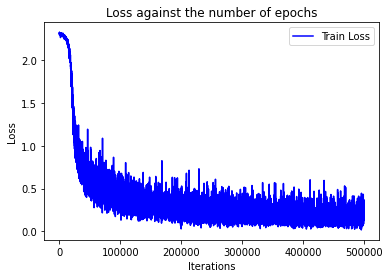

In [205]:
fig = plt.figure()
plt.title('Loss against the number of epochs')
plt.plot(train_x_axis, loss_list, color='blue')
plt.legend(['Train Loss'])
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Question 4

### Part 1

Suppose that you have a fully trained network, and that you wanted to find images that "fooled" it, i.e., images that are misclassified by your network.

One simple approach would be to take an input image, and then alter it in the direction of ascent of the gradient of the loss w.r.t to the pixels of that input image. Mathematically:

$
\begin{equation}
x^´ = x + \epsilon \,\text{sign}\left[\nabla_x \mathcal{L(\theta,x,y}) \right]
\end{equation}
$,

where $x^´$ is the (perturbed) image you hope will fool the classifier, $x$ is the input image, $y$ is the label of the original image, $\theta$ are the network parameters, $\epsilon$ is a hyperparameter controlling the strength of the perturbation, and $\mathcal{L}$ is the loss.

Implement this in Pytorch, using the model you trained in question 3. Generate one $x'$ for all the images in the MNIST testing set, keep the $x^´$ that sucessfully fool your model, alongside their original labels and their predicted (wrong) labels, and print out the accuracy of your model in the perturbed testing set (all the $x^´$ obtained from the images in the original testing set using the equation above), for the following epsilons: $\epsilon = 0,0.05,0.15,0.25$

**Hint**: A line of code similar to "data.requires_grad = True" is needed somewhere in your solution

In [206]:
epsilons = [0, .05, .15, .25]

In [207]:
def fgsm_attack(data, epsilon, grad_data):
    sign_data = grad_data.sign()
    perturbed_image = data + epsilon * sign_data 
    data_mod = torch.clamp(perturbed_image, 0, 1)
    return data_mod 

In [208]:
def fgsm_fooled_images_attack(epsilon):

    neuralNetwork.eval()
    correct, test_loss = 0, 0

    perturbed_data_list = []
    predicted_label = []
    original_label = []

    for i, (data, target) in enumerate(MNIST_train_dataloader_2):

        data.requires_grad = True
        output = neuralNetwork(data)
        initaiPred = output.data.max(1, keepdim=True)[1]
    
        loss = F.nll_loss(output, target)

        neuralNetwork.zero_grad()  

        loss.backward()

        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = neuralNetwork(perturbed_data)

        finalPred = output.data.max(1, keepdim=True)[1] 
        correct += finalPred.eq(target.data.view_as(finalPred)).sum()
        for i in range(finalPred.shape[0]):
          if finalPred[i].item() != target[i].item():
              perturbed_data_list.append(perturbed_data[i])
              predicted_label.append(finalPred[i].item())
              original_label.append(target[i])

    final_accuracy = correct/float(len(MNIST_train_dataloader_2.dataset))
    print(f"Epsilon: {epsilon} Test Accuracy = {final_accuracy*100}")
    
    return final_accuracy,perturbed_data_list, predicted_label, original_label

In [209]:
epsilons = [0,0.05,0.15,0.25]
accuracies = []
perturbed_master_list = []
predicted_label_master_list = []
original_label_master_list = []

for epsilon in epsilons:
    final_accuracy,perturbed_data_list, predicted_label, original_label = fgsm_fooled_images_attack(epsilon)
    accuracies.append(final_accuracy)
    perturbed_master_list.append(perturbed_data_list)
    predicted_label_master_list.append(predicted_label)
    original_label_master_list.append(original_label)
    

Epsilon: 0 Test Accuracy = 97.81999969482422
Epsilon: 0.05 Test Accuracy = 93.08999633789062
Epsilon: 0.15 Test Accuracy = 63.76000213623047
Epsilon: 0.25 Test Accuracy = 21.940000534057617


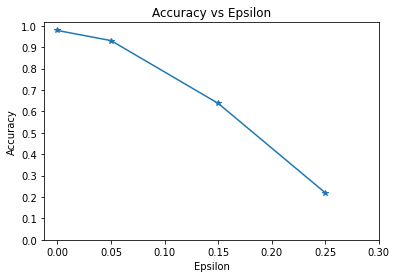

In [210]:
#plt.figure(figsize=(3,3))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Part 2

Show some of the images that fooled your network in part 1 (plt.imshow will come in handy), making sure to include both what their original and perturbed labels were in the title of your plot. Does it make sense to you that these images are fooling your network? Why or why not?

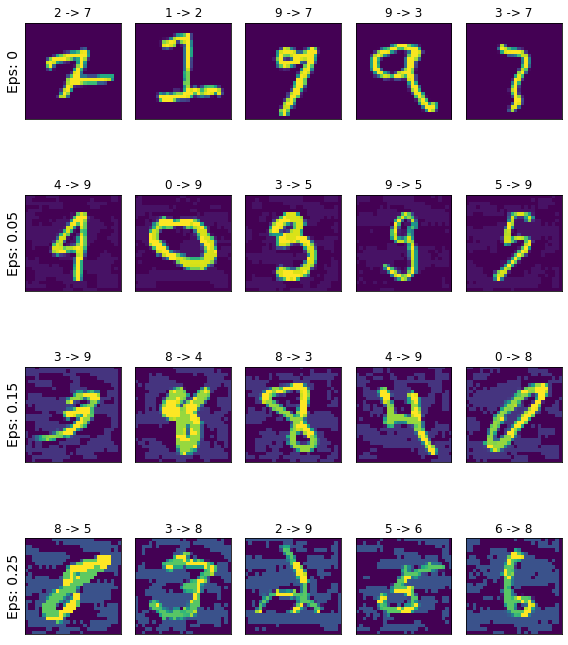

In [211]:
count = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(5):
        count += 1
        plt.subplot(len(epsilons),5,count)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        img = perturbed_master_list[i][j]
        orig = original_label_master_list[i][j]
        pred = predicted_label_master_list[i][j]
        plt.title("{} -> {}".format(orig.item(), pred))
      
        plt.imshow(img.squeeze().detach().cpu().numpy(), cmap="viridis")
plt.tight_layout()
plt.show()


**Some of the numbers are strongly correlated in terms of their structure and appearance (similarity) as visualized above, but, clearly output number is misclassified**

**As the epsilon value increases, the image becomes more difficult to identify after fgsm attack.**

## Question 5 (6505 only)

Can you think of a way to make your network more robust to these perturbed images? Does your proposal have drawbacks? Run any experiments you feel are needed to prove your claims.

**Note**: You are not expected to find a perfect solution, just something that makes sense and has some evidence backing it up. You will be marked on the persuasiveness of your argument/experiments and how much sense your proposal makes, not the overall improvements in robustness you achieve (however, if your proposal worsens the problem, then that's a pretty solid hint you're going in the wrong direction).

In [212]:
def fgsm_fooled_images_attack_train(epoch, epsilon=0.25):
    neuralNetwork.train()
    for i, (data, target) in enumerate(MNIST_train_dataloader_2):
        data.requires_grad = True
        output = neuralNetwork(data)
        loss = F.nll_loss(output, target)
        neuralNetwork.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        optimizer.zero_grad()
        output = neuralNetwork(perturbed_data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f"(Training)Epoch: {epoch} Iteration: {i} Loss: {loss.item()}")

In [213]:
for epoch in range(1, epochs+1):
    fgsm_fooled_images_attack_train(epoch)

(Training)Epoch: 1 Iteration: 0 Loss: 1.9380748271942139
(Training)Epoch: 1 Iteration: 10 Loss: 1.312681794166565
(Training)Epoch: 1 Iteration: 20 Loss: 1.5345152616500854
(Training)Epoch: 1 Iteration: 30 Loss: 1.7555649280548096
(Training)Epoch: 1 Iteration: 40 Loss: 1.5578069686889648
(Training)Epoch: 1 Iteration: 50 Loss: 1.3843722343444824
(Training)Epoch: 1 Iteration: 60 Loss: 1.4547233581542969
(Training)Epoch: 1 Iteration: 70 Loss: 1.5883184671401978
(Training)Epoch: 1 Iteration: 80 Loss: 1.333191990852356
(Training)Epoch: 1 Iteration: 90 Loss: 1.4354767799377441
(Training)Epoch: 1 Iteration: 100 Loss: 1.614338755607605
(Training)Epoch: 1 Iteration: 110 Loss: 1.323824167251587
(Training)Epoch: 1 Iteration: 120 Loss: 1.3133496046066284
(Training)Epoch: 1 Iteration: 130 Loss: 1.4828020334243774
(Training)Epoch: 1 Iteration: 140 Loss: 1.5078190565109253
(Training)Epoch: 1 Iteration: 150 Loss: 1.3091193437576294
(Training)Epoch: 2 Iteration: 0 Loss: 1.2626330852508545
(Training)Epoc

In [214]:
def fgsm_fooled_images_attack_next(epsilon):

    neuralNetwork.eval()
    correct, test_loss = 0, 0
  
    perturbed_data_list = []
    predicted_label = []
    original_label = []

    for data, target in MNIST_test_dataloader:

        data.requires_grad = True
        output = neuralNetwork(data)
        initialPred = output.data.max(1, keepdim=True)[1]
       
        loss = F.nll_loss(output, target)

        neuralNetwork.zero_grad()   

        loss.backward()

        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = neuralNetwork(perturbed_data)

        finalPred = output.max(1, keepdim=True)[1] 
        correct += finalPred.eq(target.data.view_as(finalPred)).sum()

        for i in range(finalPred.shape[0]):
            if finalPred[i].item() != target[i].item():
                perturbed_data_list.append(perturbed_data[i])
                predicted_label.append(finalPred[i].item())
                original_label.append(target[i])


    final_accuracy = correct/float(len(MNIST_test_dataloader.dataset))
    print(f"Epsilon: {epsilon} Test Accuracy = {final_accuracy*100}")
    
    return final_accuracy,perturbed_data_list, predicted_label, original_label

In [215]:
epsilons = [0,0.05,0.15,0.25]
accuracies = []
perturbed_master_list = []
predicted_label_master_list = []
original_label_master_list = []

for epsilon in epsilons:
    final_accuracy,perturbed_data_list, predicted_label, original_label = fgsm_fooled_images_attack_next(epsilon)
    accuracies.append(final_accuracy)
    perturbed_master_list.append(perturbed_data_list)
    predicted_label_master_list.append(predicted_label)
    original_label_master_list.append(original_label)

Epsilon: 0 Test Accuracy = 96.83999633789062
Epsilon: 0.05 Test Accuracy = 94.23999786376953
Epsilon: 0.15 Test Accuracy = 84.55999755859375
Epsilon: 0.25 Test Accuracy = 67.04000091552734


**I ran the above code in Step 5 to make the network more robust to these perturbed images. I trained the network first on the spiltted training dataset of 10K images. Therefore, now the training is done on both the original and perturbed images uisng fast gradient method**

**Then, the fgm attack is again performed on the trained perturbed images.**

**After performing fgsm attack attack and adding epsilons to the run, the accuracy did drop drasticalling after increasing the epsilon value. It somewhat improved.**

**One drawback of this way is that if the input images resides in the blind-spot, model will not behave properly.**